---
layout: post
title: SIR Model Fit for COVID-19
category: data science
tags:
    - python
    - notebook
    - COVID-19
---

COVID-19 has been declared a global pandemic. It is on the news constantly and everyone is trying to do their part by participating in "social distancing" to slow the spread of the virus. The future is very uncertain right now, so to see if we can learn a little bit about what will happen I am going to take a dive into the data we have on COVID-19 and see if we can fit a mathematical model to its global spread. Can we make any solid predictions on how the virus will spread next?

# Disclaimer:

I do not expect very accurate results. This is for learning purposes only!

# [Base SIR Model](https://mathworld.wolfram.com/Kermack-McKendrickModel.html)

SIR stands for susceptible, infected, removed. It is a compartmental mathematical model that puts the entire population in one of 3 groups:

- susceptible: healthy, but susceptible for the virus
- infected: infected and infectious
- removed: either healthy and immune, or passed due to the virus.

The SIR model defines an [ODE](https://mathworld.wolfram.com/OrdinaryDifferentialEquation.html) which describes the growth and movement of people from group to group over time:

$$
\frac{dS}{dt} = -\frac{\beta S I}{N} \\
\frac{dI}{dt} = \frac{\beta S I}{N} - \gamma I \\
\frac{dR}{dt} = \gamma I
$$

There are two parameters that define the growth of the model:

- $\beta$: The infection rate
- $\gamma$: Inverse mean recovery rate

## Data

Due to limitations on how COVID-19 cases are reported, it is infeasible to get accurate statistics on how many people are still active with COVID-19 and who has healthily recovered. This means that there is a blurred line between the "infected" and "recovered" set. However, there are relatively accurate results on how many people have passed away from the virus. Let's change our compartments a little so that our model reflects our data more effectively:

$$
\frac{dS}{dt} = -\frac{\beta S I}{N} \\
\frac{dI}{dt} = \frac{\beta S I}{N} - (\gamma + \alpha) I \\
\frac{dR}{dt} = \gamma I \\
\frac{dD}{dt} = \alpha I
$$

Now we have 4 compartments, SIRD:

- Susceptible
- Infected
- Recovered
- Dead

With 3 variables:

- $\alpha$: Death rate
- $\gamma$: Recovery rate
- $\beta$: Infection rate

When looking at our data, we will treat $I + R = C$ as our confirmed cases set.

## Example

In [42]:
import os
import glob
import numpy as np
import pandas as pd
from git import Repo
from scipy import optimize
from datetime import datetime
from datetime import timedelta
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_log_error as MSLE

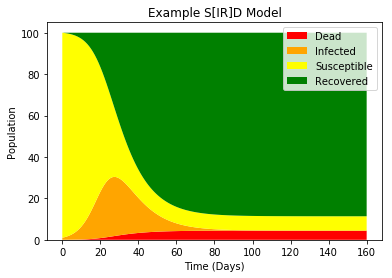

In [43]:
# Total population, N.
N = 100
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0, D0 = 1, 0, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0 - D0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
alpha, beta, gamma = 0.005, 0.3, 1/10 
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

# The SIR model differential equations.
def SIRD_ode(y, t, N, alpha, beta, gamma):
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - (gamma + alpha) * I
    dRdt = gamma * I
    dDdt = alpha * I
    return dSdt, dIdt, dRdt, dDdt

# Initial conditions vector
y0 = S0, I0, R0, D0
# Integrate the SIR equations over the time grid, t.
ret = odeint(SIRD_ode, y0, t, args=(N, alpha, beta, gamma))
S, I, R, D = ret.T

# Plot the data on three separate curves for S(t), I(t) and R(t)
plt.title("Example S[IR]D Model")
plt.stackplot(t, [D, I, S, R],
              labels=["Dead", "Infected", "Susceptible", "Recovered"],
              colors=["red", "orange", "yellow", "green"])
plt.xlabel('Time (Days)')
plt.ylabel('Population')
plt.legend()
plt.show()

By solving the ODE we can see some neat growth and improvement of this virus over time.

## Fit to Data

I am using JHU's [COVID-19 dataset](https://github.com/CSSEGISandData/COVID-19) which has time series data on every country that reports having COVID-19. This dataset is very active, and updates at least twice a week. We will use gitPython to get the most up-to-date data we can find.

In [44]:
repo_path = "../../../"
data_root = "../../../scripts/COVID-19/csse_covid_19_data/csse_covid_19_time_series/"
repo = Repo(repo_path)
output = repo.git.submodule('update', '--remote')

In [45]:
china_pop = 1.386e9
world_pop = 7.8e9 # 7.8e9

global_confirmed = pd.read_csv(os.path.join(data_root, "time_series_covid19_confirmed_global.csv"))
global_deaths = pd.read_csv(os.path.join(data_root, "time_series_covid19_deaths_global.csv"))

china_confirmed = global_confirmed[global_confirmed['Country/Region'] == "China"].copy()
china_deaths = global_deaths[global_deaths['Country/Region'] == "China"].copy()
china_deaths.drop(columns=["Province/State", "Country/Region", "Lat", "Long"], inplace=True)
china_confirmed.drop(columns=["Province/State", "Country/Region", "Lat", "Long"], inplace=True)
global_deaths.drop(columns=["Province/State", "Country/Region", "Lat", "Long"], inplace=True)
global_confirmed.drop(columns=["Province/State", "Country/Region", "Lat", "Long"], inplace=True)

global_confirmed = global_confirmed.sum()
global_deaths = global_deaths.sum()
china_confirmed = china_confirmed.sum()
china_deaths = china_deaths.sum()

world_df = pd.DataFrame({
    "Susceptible": world_pop - global_confirmed.values - global_deaths.values,
    "Confirmed": global_confirmed,
    "Deaths": global_deaths
})

china_df = pd.DataFrame({
    "Confirmed": china_confirmed,
    "Deaths": china_deaths
})
china_df["Susceptible"] = china_df.sum(axis=1).max() - china_confirmed.values - china_deaths.values

Now we have aggregated data for China - the origin of the disease - and the entire world. Let's split up data into training and validation data by removing the last 7 days from the training set.

In [46]:
def train_valid_split(df, valid_size = 7):
    x = np.arange(len(df))
    S = df['Susceptible'].values
    C = df['Confirmed'].values
    D = df['Deaths'].values
    
    x_train = x[:-valid_size]
    S_train = S[:-valid_size]
    C_train = C[:-valid_size]
    D_train = D[:-valid_size]
    
    x_valid = x[-valid_size:]
    S_valid = S[-valid_size:]
    C_valid = C[-valid_size:]
    D_valid = D[-valid_size:]
    
    return (x_train, S_train, C_train, D_train), (x_valid, S_valid, C_valid, D_valid)

def plot_data(title, x_train, y_train, x_valid, y_valid, y_fit = None, y_pred = None):
    plt.title(title)
    plt.plot(x_train, y_train, 'o', label="Train")
    plt.plot(x_valid, y_valid, 'o', label="Valid")
    if not y_fit is None:
        plt.plot(x_train, y_fit, label="Fit")
    if not y_pred is None:
        plt.plot(x_valid, y_pred, label="Prediction")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Population")
    plt.show()

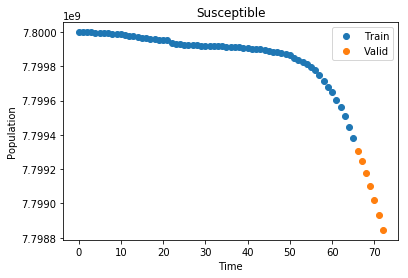

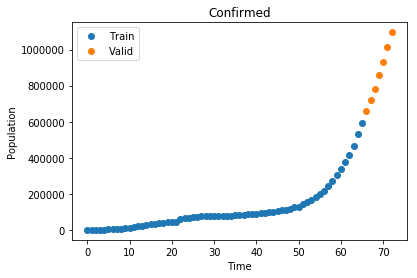

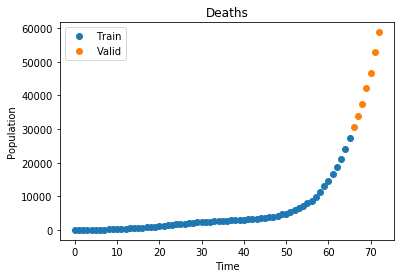

In [47]:
train, valid = train_valid_split(world_df)
x_train, S_train, C_train, D_train = train
x_valid, S_valid, C_valid, D_valid = valid

plot_data("Susceptible", x_train, S_train, x_valid, S_valid)
plot_data("Confirmed", x_train, C_train, x_valid, C_valid)
plot_data("Deaths", x_train, D_train, x_valid, D_valid)

Now that we have our data we define our optimization function, which takes all three curves and performs a least squares optimization to find the best values for $\alpha$ and $\beta$

NOTE: I made use of China's curve fit to find $\gamma$ as this model is difficult to project on the entire world's population otherwise.

In [48]:
def opt_func(t, beta, gamma, SIRD0, N):
    alpha = death_rate * gamma
    ret = odeint(SIRD_ode, SIRD0, t, args=(N, alpha, beta, gamma))
    S, I, R, D = ret.T
    C = I + R
    return np.concatenate([S, C, D])

In [49]:
death_rate = 0.035

# Data
train, valid = train_valid_split(world_df)
x_train, S_train, C_train, D_train = train
x_valid, S_valid, C_valid, D_valid = valid

# Initial Conditions:
S0 = S_train[0]
C0 = C_train[0]
D0 = D_train[0]
SIRD0 = S0, C0, 0, D0
N = sum(SIRD0)

(beta, gamma), _ = optimize.curve_fit(lambda t, b, g: opt_func(t, b, g, SIRD0, N),
                                      x_train, np.concatenate([S_train, C_train, D_train]),
                                      bounds=((0, 0), (np.inf, 1)),
                                      p0 = (1, 0))
alpha = death_rate * gamma
alpha, beta, gamma

(0.013505874744460186, 0.47761072758073086, 0.38588213555600526)

In [50]:
fit = odeint(SIRD_ode, SIRD0, np.concatenate([x_train, x_valid]), args=(N, alpha, beta, gamma))
S_fit, I_fit, R_fit, D_fit = fit.T
C_fit = I_fit + R_fit
S_pred = S_fit[len(x_train):]
C_pred = C_fit[len(x_train):]
D_pred = D_fit[len(x_train):]
S_fit = S_fit[:len(x_train)]
C_fit = C_fit[:len(x_train)]
D_fit = D_fit[:len(x_train)]

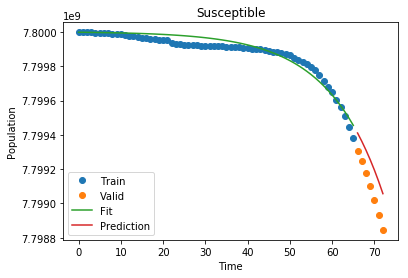

Susceptible MSLE: 4.1756565419903203e-10



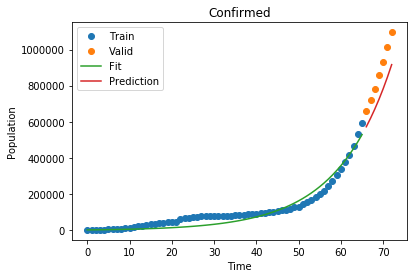

Confirmed MSLE: 0.02727328741251841



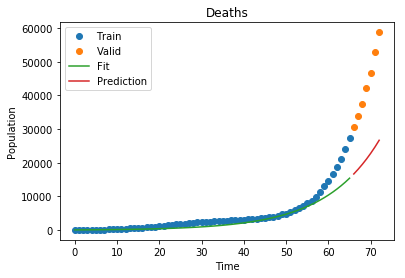

Deaths MSLE: 0.48725530839980313



In [51]:
plot_data("Susceptible", x_train, S_train, x_valid, S_valid, S_fit, S_pred)
print("Susceptible MSLE:", MSLE(S_valid, S_pred))
print()
plot_data("Confirmed", x_train, C_train, x_valid, C_valid, C_fit, C_pred)
print("Confirmed MSLE:", MSLE(C_valid, C_pred))
print()
plot_data("Deaths", x_train, D_train, x_valid, D_valid, D_fit, D_pred)
print("Deaths MSLE:", MSLE(D_valid, D_pred))
print()

As of right now, our model fits the world data decently! Let's see how it fares on a part of the world that is already a little farther ahead of the curve, like China. Here, the last part of China's curve has already started to flatten! We can take that into account by not including ALL of china's 1.8 billion residents, just the people that are accounted for in the data:

In [52]:
# Data
train, valid = train_valid_split(china_df)
x_train, S_train, C_train, D_train = train
x_valid, S_valid, C_valid, D_valid = valid

# Initial Conditions:
S0 = S_train[0]
C0 = C_train[0]
D0 = D_train[0]
SIRD0 = S0, C0, 0, D0
N = sum(SIRD0)

(beta, gamma), _ = optimize.curve_fit(lambda t, b, g: opt_func(t, b, g, SIRD0, N),
                                      x_train, np.concatenate([S_train, C_train, D_train]),
                                      bounds=((0, 0), (np.inf, 1)),
                                      p0=(1, 0))
alpha = gamma * death_rate
alpha, beta, gamma

(0.003241798634737625, 0.36926387188639626, 0.0926228181353607)

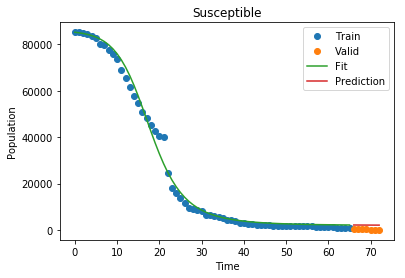

Susceptible MSLE: 12.507098349037452



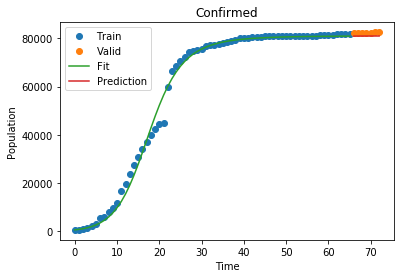

Confirmed MSLE: 0.00027200436667063754



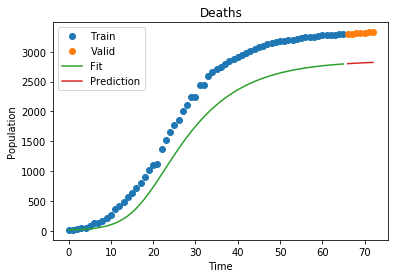

Deaths MSLE: 0.026847939860911513



In [53]:
fit = odeint(SIRD_ode, SIRD0, np.concatenate([x_train, x_valid]), args=(N, alpha, beta, gamma))
S_fit, I_fit, R_fit, D_fit = fit.T
C_fit = I_fit + R_fit
S_pred = S_fit[len(x_train):]
C_pred = C_fit[len(x_train):]
D_pred = D_fit[len(x_train):]
S_fit = S_fit[:len(x_train)]
C_fit = C_fit[:len(x_train)]
D_fit = D_fit[:len(x_train)]

plot_data("Susceptible", x_train, S_train, x_valid, S_valid, S_fit, S_pred)
print("Susceptible MSLE:", MSLE(S_valid, S_pred))
print()
plot_data("Confirmed", x_train, C_train, x_valid, C_valid, C_fit, C_pred)
print("Confirmed MSLE:", MSLE(C_valid, C_pred))
print()
plot_data("Deaths", x_train, D_train, x_valid, D_valid, D_fit, D_pred)
print("Deaths MSLE:", MSLE(D_valid, D_pred))
print()

It looks like with some feature engineering and mathematical modeling, we can make quite good short term predictions on how the virus will spread.

# Long-Term Predictions:

Let's fit our model on all of our data and see if we can make some longer term predictions:

In [54]:
# Data
train, valid = train_valid_split(world_df)
x_train, S_train, C_train, D_train = train
x_valid, S_valid, C_valid, D_valid = valid

# Initial Conditions:
S0 = S_train[0]
C0 = C_train[0]
D0 = D_train[0]
SIRD0 = S0, C0, 0, D0
N = sum(SIRD0)

x = np.concatenate([x_train, x_valid])
S = np.concatenate([S_train, S_valid])
C = np.concatenate([C_train, C_valid])
D = np.concatenate([D_train, D_valid])

(beta, gamma), _ = optimize.curve_fit(lambda t, b, g: opt_func(t, b, g, SIRD0, N),
                                      x, np.concatenate([S, C, D]),
                                      bounds=((0, 0.074591), (np.inf, 0.074592)))
alpha = death_rate * gamma
alpha, beta, gamma

(0.0026107199999628214, 0.17549614633670074, 0.07459199999893774)

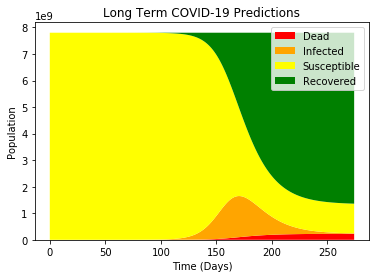

In [55]:
t = np.arange(275)

fit = odeint(SIRD_ode, SIRD0, t, args=(N, alpha, beta, gamma))
S_fit, I_fit, R_fit, D_fit = fit.T
C_fit = I_fit + R_fit

plt.stackplot(t, [D_fit, I_fit, S_fit, R_fit],
              labels=["Dead", "Infected", "Susceptible", "Recovered"],
              colors=["red", "orange", "yellow", "green"])
plt.legend()
plt.title("Long Term COVID-19 Predictions")
plt.xlabel("Time (Days)")
plt.ylabel("Population")
plt.show()

In [56]:
inflection = datetime.strptime(world_df.iloc[0].name, "%m/%d/%y") + timedelta(days=int(np.argmax(I_fit)))
death_toll = max(D_fit)
confirmed = max(I_fit + R_fit)
simul_infected = max(I_fit)
death_rate = death_toll / (confirmed + death_toll)
print("Predicted Total Confirmed Cases: {:.2e}".format(confirmed))
print("Predicted Death Rate: {:.2f}%".format(death_rate * 100))
print("Predicted Total Deaths: {:.2e}".format(death_toll))
print("Predicted Most Simultaneously Infected: {:.2e}".format(simul_infected))
print("Predicted Inflection Point:", inflection)

Predicted Total Confirmed Cases: 6.46e+09
Predicted Death Rate: 3.37%
Predicted Total Deaths: 2.25e+08
Predicted Most Simultaneously Infected: 1.55e+09
Predicted Inflection Point: 2020-07-09 00:00:00


It looks like this model is suggesting that within a year, the majority of the world population will have been infected with COVID-19, and a predicted death toll of just under 700 million. Additionally, the model predicts the "peak" of the infected curve to be around early July.

# Conclusion

To me, these predictions look extreme. Mostly considering that the majority of the world is practicing social distancing and quarantining confirmed infected people, which is not reflected in this model. The more data we receive, the better we will be able to model and predict the spread of the virus over the next weeks and months.

If you would like to learn more, take a look at the following resources:

- [WHO COVID-19 Website](https://www.who.int/emergencies/diseases/novel-coronavirus-2019)
- [CDC COVID-19 Website](https://www.cdc.gov/coronavirus/2019-nCoV/index.html)
- [Washington Post Article](https://www.washingtonpost.com/graphics/2020/world/corona-simulator/) With some nifty simulations on how a virus spreads under different conditions.
- [Base SIR Model](https://mathworld.wolfram.com/Kermack-McKendrickModel.html)
- [JHU COVID-19 Dataset](https://github.com/CSSEGISandData/COVID-19) The dataset I used to model the virus
- [JHU Lancet Article](https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30144-4/fulltext) Modeling the early spread of the virus.